In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from PIL import Image
from itertools import product
from dataclasses import dataclass
from collections import namedtuple, defaultdict
from markov import MarkovSampler, ngramLearner
from pos_encoder import RotaryPositionalEmbeddings, RelativePositionalEncoding
from attention import *
from config import Config

We are going to build attention-only TF and the regular TF below, and train them on synthetic markov data.

In [3]:
class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.emb_dim = config.emb_dim
        self.n_head = config.num_heads
        self.head_dim = self.emb_dim // self.n_head
        assert self.emb_dim % self.n_head == 0, "Embedding dimension must be divisible by the number of heads."
        self.query = nn.Linear(self.emb_dim, self.emb_dim)
        self.key = nn.Linear(self.emb_dim, self.emb_dim)
        self.value = nn.Linear(self.emb_dim, self.emb_dim)
        self.out = nn.Linear(self.emb_dim, self.emb_dim)
        self.mask = torch.tril(torch.ones(config.seq_len, config.seq_len)).unsqueeze(0).unsqueeze(1)
        self.mask = self.mask.to(config.device)
        self.get_attn = config.get_attn
        self.pos_enc = config.pos_enc
        self.seq_len = config.seq_len
        self.pos_max_len = config.pos_max_len
        self.scale = self.head_dim ** 0.5
        self.flash = config.flash
        assert not (self.flash and self.pos_enc == "rpe"), "Flash Attention does not support RPE currently."  
        if self.flash:
            self.flashAttend = FlashAttend(config)
        if self.pos_enc == "rpe":
            self.PEK = RelativePositionalEncoding(self.head_dim, self.pos_max_len)
            self.PEV = RelativePositionalEncoding(self.head_dim, self.pos_max_len)
        elif self.pos_enc == "rotary":
            self.rotary_emb = RotaryPositionalEmbeddings(self.head_dim, self.pos_max_len)

    def forward(self, x): # (B,T,C)
        batch_size, seq_len, embed_dim = x.size()
        Q = self.query(x).view(batch_size, seq_len, self.n_head, self.head_dim).transpose(1,2) # (B,H,T,D)
        K = self.key(x).view(batch_size, seq_len, self.n_head, self.head_dim).transpose(1,2) # (B,H,T,D)
        V = self.value(x).view(batch_size, seq_len, self.n_head, self.head_dim).transpose(1,2) # (B,H,T,D)
        if self.pos_enc == "rotary":
            Q = self.rotary_emb(Q)
            K = self.rotary_emb(K)
        if self.flash:
            assert self.get_attn == 0, "Flash Attention does not output attentions."
            return self.flashAttend(Q, K, V)
            
        attn_score = Q @ K.transpose(-1,-2) / self.scale
        if self.pos_enc=="rpe":
            # Each B and H, Q_i@(K_j+pe_{i-j}) instead of Q_i@K_j
            # Create a matrix Pos where Pos_{i,j} = pe_{i-j}: \R^D, |i-j| <= max_len <= seq_len
            Q2 = self.query(x).transpose(0,1).view(seq_len,-1,self.head_dim) # (T,B*H,D)
            attn_score2 = torch.matmul(Q2, self.PEK(seq_len).transpose(1,2)) # (T,B*H,D) @ (T,D,T) -> (T,B*H,T)
            attn_score2 = attn_score2.transpose(0,1).contiguous().view(batch_size, -1, seq_len, seq_len) # (B,H,T,T)
            attn_score += attn_score2 / self.scale
        attn_score = attn_score.masked_fill(self.mask==0, -float("inf"))
        attn = F.softmax(attn_score, dim=-1) # (B,H,T,T)
        out = attn @ V # (B,H,T,D)
        if self.pos_enc=="rpe":
            attn2 = attn.view(-1,seq_len,seq_len).transpose(0,1) # (T, B*H, T)
            out2 = torch.matmul(attn2, self.PEV(seq_len)) # (T, B*H, T) @ (T, T, D) -> (T, B*H, D)
            out2 = out2.transpose(0,1).contiguous().view(batch_size, -1, seq_len, self.head_dim) # (B, H, T, D)
            out += out2
        out = out.transpose(1,2).contiguous().view(batch_size,seq_len,-1) # (B, T, C)
        out = self.out(out)
        if self.get_attn > 0:
            return out, attn.detach().cpu() 
        return out
        
        
class TFBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.MHA = MultiHeadAttention(config)
        self.ln1 = nn.LayerNorm(config.emb_dim) if config.layer_norm else None
        self.mlp = None
        self.dropout = None
        self.get_attn = config.get_attn

        if config.mlp:
            assert config.ff_dim is not None, "FeedForward dimension cannot be empty."
            self.mlp = nn.Sequential(
                nn.Linear(config.emb_dim, config.ff_dim),
                nn.ReLU(),
                nn.Linear(config.ff_dim, config.emb_dim)
            )
            self.ln2 = nn.LayerNorm(config.emb_dim)
            
        if config.dropout:
            self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        attn_map = None
        if self.get_attn > 0:
            atten_out, attn_map = self.MHA(x)
        else:
            atten_out = self.MHA(x)
        x = x + self.dropout(atten_out) if self.dropout else x + atten_out
        if self.ln1 is not None:
            x = self.ln1(x)
        if self.mlp is not None:
            mlp_out = self.mlp(x)
            if self.dropout is not None:
                x = self.ln2(x + self.dropout(mlp_out))
            else:
                x = self.ln2(x + mlp_out)
        if self.get_attn > 0:
            return x, attn_map 
        return x
        
class Transformer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embed = nn.Embedding(config.vocab_size, config.emb_dim).to(config.device)
        self.pos_enc = config.pos_enc
        if config.pos_enc == "abs":
            self.positional_encoding = nn.Parameter(torch.zeros(1, config.seq_len, config.emb_dim)).to(config.device)
        self.layers = nn.ModuleList([TFBlock(config) for _ in range(config.num_layers)])
        self.output_layer = nn.Linear(config.emb_dim, config.vocab_size)
        self.get_attn = config.get_attn
        if self.get_attn > 0:
            self.atten_maps = torch.zeros((config.num_layers, config.num_heads, config.seq_len, config.seq_len))

    def forward(self, x):
        if self.pos_enc == "abs":
            x = self.embed(x) + self.positional_encoding[:, :x.size(1), :]
        else:
            x = self.embed(x)
        for i, layer in enumerate(self.layers):
            if self.get_attn > 0:
                x, attn_map = layer(x)
                self.atten_maps[i] = attn_map.mean(dim=0)
            else:
                x = layer(x)

        logits = self.output_layer(x)
        if self.get_attn > 0: 
            return logits, self.atten_maps 
        return logits

In [6]:
config = Config(
        emb_dim=128,
        num_heads=1,
        num_layers=3,
        seq_len=64,
        vocab_size=5,
        batch_size=1024,
        test_size=2048,
        num_epochs=1000,
        eval_iter=50,
        order=3,
        device='cuda',
        get_attn=0,
        mlp=True,
        ff_dim=128,
        flash=False,
    )
model = Transformer(config)
model = model.to(config.device)

ngramLearnerDict = {i:ngramLearner(config.vocab_size, i) for i in range(4)}
ngramLosses = defaultdict(list)

config.device

'cuda'

In [7]:
def train(model, config):
    sampler = MarkovSampler(config)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
    train_losses, eval_losses, eval_steps = [], [], []
    test_data = sampler.generate(mode="test")
    test_y = test_data[:,1:].reshape(-1).to(config.device)
    attn_maps, test_attn_maps = {}, {}
    for epoch in trange(config.num_epochs):
        model.train()
        batch = sampler.generate() # bottleneck
        optimizer.zero_grad()
        targets = batch[:,1:]
        if config.get_attn > 0 and epoch % config.get_attn == 0:
            outputs, attn = model(batch.to(config.device))
            attn_maps[epoch] = attn.clone()
        else:
            if config.get_attn > 0:
                outputs, _ = model(batch.to(config.device))
            else:
                outputs = model(batch.to(config.device)) 

        outputs = outputs[:,:-1,:].reshape(-1, config.vocab_size)

        for i, learner in ngramLearnerDict.items():
            ngram_loss = learner.loss(batch)
            ngramLosses[i].append(ngram_loss)
            learner.update(batch)
        
        targets = targets.reshape(-1)
        targets = targets.to(config.device)
        loss = criterion(outputs, targets)
            
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
        if epoch % config.eval_iter == 0:
            with torch.no_grad():
                model.eval()
                if config.get_attn > 0:
                    outputs, test_attn_maps = model(test_data.to(config.device))
                else:
                    outputs = model(test_data.to(config.device))
                outputs = outputs[:,:-1,:].reshape(-1, config.vocab_size)
                loss = criterion(outputs, test_y)
                eval_losses.append(loss.item())
                eval_steps.append(epoch)
                # print(f"Epoch: {epoch}, Evaluation loss: {loss.item()}")
    return train_losses, eval_losses, eval_steps, attn_maps, test_attn_maps

In [826]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [8]:
train_losses, eval_losses, eval_steps, attn_maps, test_attn_maps = train(model, config)

100%|██████████| 1000/1000 [01:02<00:00, 15.95it/s]


In [266]:
%lprun -f train train(model, config)

100%|██████████| 1000/1000 [00:22<00:00, 45.06it/s]


Timer unit: 1e-07 s

Total time: 22.2066 s
File: C:\Users\Hao\AppData\Local\Temp\ipykernel_35372\1150200367.py
Function: train at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def train(model, config):
     2         1      93304.0  93304.0      0.0      sampler = MarkovSampler(config)
     3         1       1052.0   1052.0      0.0      criterion = nn.CrossEntropyLoss()
     4         1       3503.0   3503.0      0.0      optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
     5         1          6.0      6.0      0.0      train_losses, eval_losses, eval_steps, bi_losses, four_losses = [], [], [], [], []
     6         1     247947.0 247947.0      0.1      test_data = sampler.generate(mode="test")
     7         1      11248.0  11248.0      0.0      test_y = test_data[:,1:].reshape(-1).to(config.device)
     8         1          8.0      8.0      0.0      attn_maps, test_attn_maps = {}, {

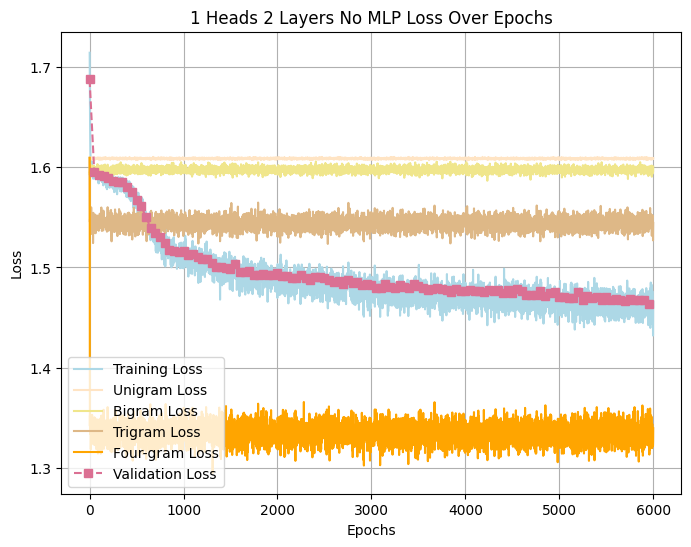

In [233]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, config.num_epochs + 1), train_losses, linestyle='-', color='lightblue', label='Training Loss')
plt.plot(range(1, config.num_epochs + 1), uni_losses, linestyle='-', color='bisque', label='Unigram Loss')
plt.plot(range(1, config.num_epochs + 1), bi_losses, linestyle='-', color='khaki', label='Bigram Loss')
plt.plot(range(1, config.num_epochs + 1), tri_losses, linestyle='-', color='burlywood', label='Trigram Loss')
plt.plot(range(1, config.num_epochs + 1), four_losses, linestyle='-', color='orange', label='Four-gram Loss')
plt.plot(eval_steps, eval_losses, marker='s', linestyle='--', color='palevioletred', label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('1 Heads 2 Layers No MLP Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

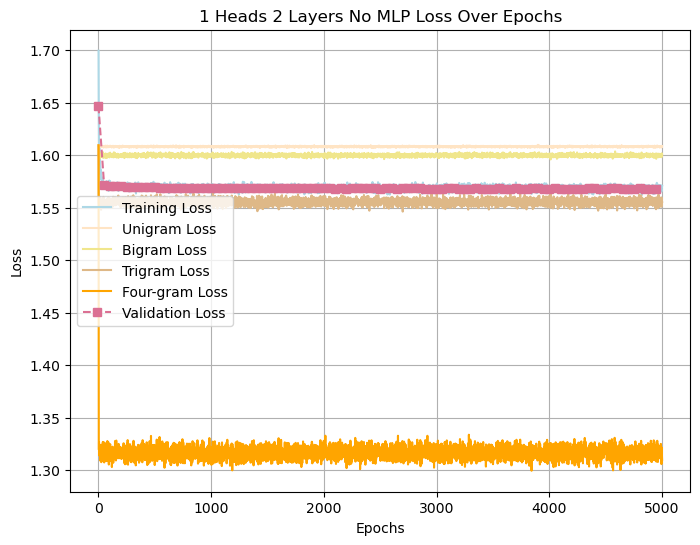

In [808]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, config.num_epochs + 1), train_losses, linestyle='-', color='lightblue', label='Training Loss')
plt.plot(range(1, config.num_epochs + 1), ngramLosses[0], linestyle='-', color='bisque', label='Unigram Loss')
plt.plot(range(1, config.num_epochs + 1), ngramLosses[1], linestyle='-', color='khaki', label='Bigram Loss')
plt.plot(range(1, config.num_epochs + 1), ngramLosses[2], linestyle='-', color='burlywood', label='Trigram Loss')
plt.plot(range(1, config.num_epochs + 1), ngramLosses[3], linestyle='-', color='orange', label='Four-gram Loss')
plt.plot(eval_steps, eval_losses, marker='s', linestyle='--', color='palevioletred', label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('1 Heads 2 Layers No MLP Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

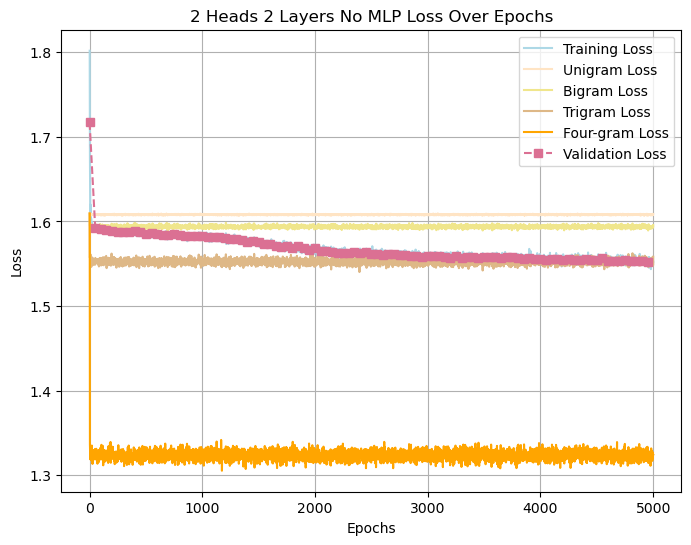

In [814]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, config.num_epochs + 1), train_losses, linestyle='-', color='lightblue', label='Training Loss')
plt.plot(range(1, config.num_epochs + 1), ngramLosses[0], linestyle='-', color='bisque', label='Unigram Loss')
plt.plot(range(1, config.num_epochs + 1), ngramLosses[1], linestyle='-', color='khaki', label='Bigram Loss')
plt.plot(range(1, config.num_epochs + 1), ngramLosses[2], linestyle='-', color='burlywood', label='Trigram Loss')
plt.plot(range(1, config.num_epochs + 1), ngramLosses[3], linestyle='-', color='orange', label='Four-gram Loss')
plt.plot(eval_steps, eval_losses, marker='s', linestyle='--', color='palevioletred', label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('2 Heads 2 Layers No MLP Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

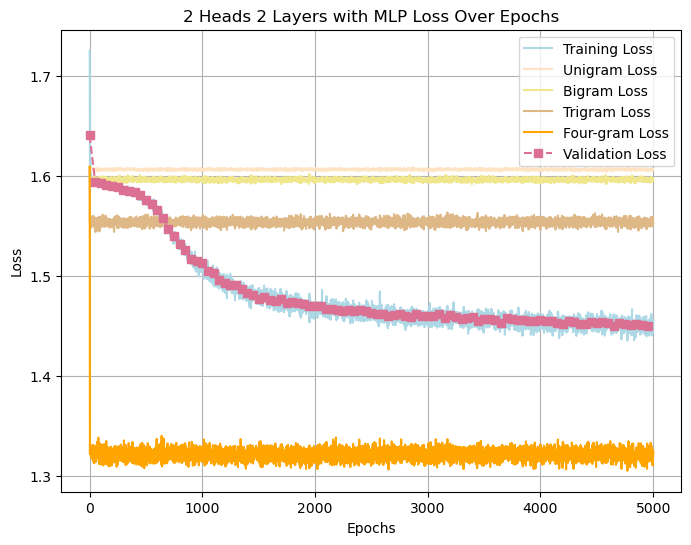

In [828]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, config.num_epochs + 1), train_losses, linestyle='-', color='lightblue', label='Training Loss')
plt.plot(range(1, config.num_epochs + 1), ngramLosses[0], linestyle='-', color='bisque', label='Unigram Loss')
plt.plot(range(1, config.num_epochs + 1), ngramLosses[1], linestyle='-', color='khaki', label='Bigram Loss')
plt.plot(range(1, config.num_epochs + 1), ngramLosses[2], linestyle='-', color='burlywood', label='Trigram Loss')
plt.plot(range(1, config.num_epochs + 1), ngramLosses[3], linestyle='-', color='orange', label='Four-gram Loss')
plt.plot(eval_steps, eval_losses, marker='s', linestyle='--', color='palevioletred', label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('2 Heads 2 Layers with MLP Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

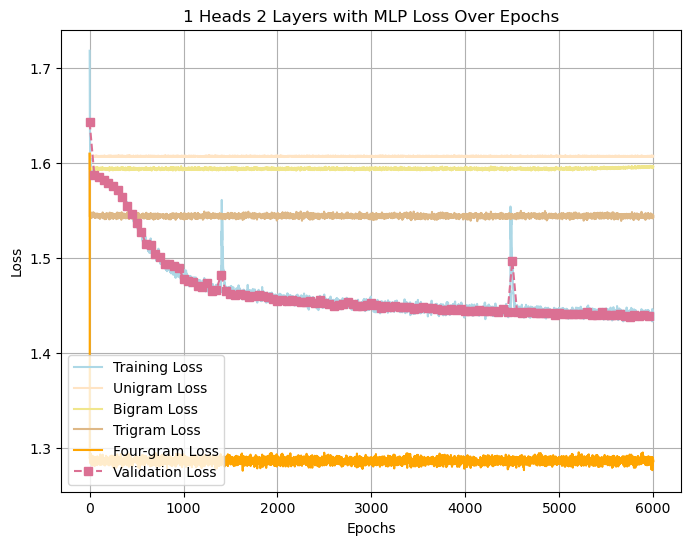

In [832]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, config.num_epochs + 1), train_losses, linestyle='-', color='lightblue', label='Training Loss')
plt.plot(range(1, config.num_epochs + 1), ngramLosses[0], linestyle='-', color='bisque', label='Unigram Loss')
plt.plot(range(1, config.num_epochs + 1), ngramLosses[1], linestyle='-', color='khaki', label='Bigram Loss')
plt.plot(range(1, config.num_epochs + 1), ngramLosses[2], linestyle='-', color='burlywood', label='Trigram Loss')
plt.plot(range(1, config.num_epochs + 1), ngramLosses[3], linestyle='-', color='orange', label='Four-gram Loss')
plt.plot(eval_steps, eval_losses, marker='s', linestyle='--', color='palevioletred', label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('1 Heads 2 Layers with MLP Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

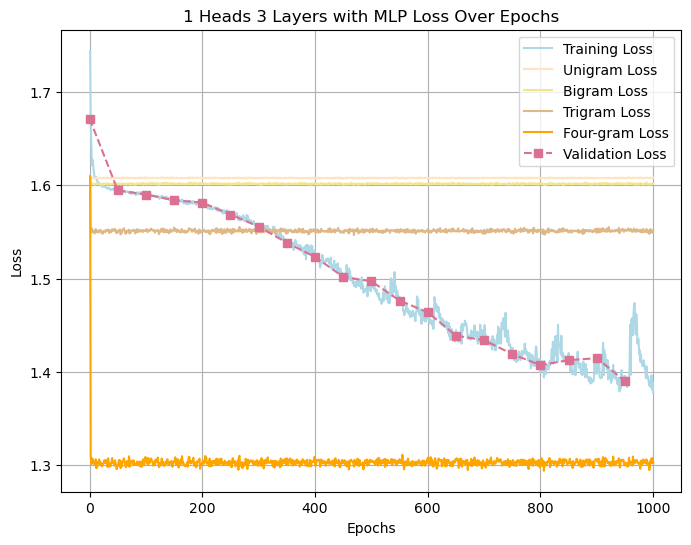

In [9]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, config.num_epochs + 1), train_losses, linestyle='-', color='lightblue', label='Training Loss')
plt.plot(range(1, config.num_epochs + 1), ngramLosses[0], linestyle='-', color='bisque', label='Unigram Loss')
plt.plot(range(1, config.num_epochs + 1), ngramLosses[1], linestyle='-', color='khaki', label='Bigram Loss')
plt.plot(range(1, config.num_epochs + 1), ngramLosses[2], linestyle='-', color='burlywood', label='Trigram Loss')
plt.plot(range(1, config.num_epochs + 1), ngramLosses[3], linestyle='-', color='orange', label='Four-gram Loss')
plt.plot(eval_steps, eval_losses, marker='s', linestyle='--', color='palevioletred', label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('1 Heads 3 Layers with MLP Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

In [235]:
image_paths = []
layer = 1
head = 0
folder = "attns"
for i, attn in attn_maps.items():
    # Create heatmap
    plt.figure(figsize=(6, 5))
    plt.imshow(attn[layer][head], cmap="viridis", interpolation="nearest")
    plt.colorbar()
    plt.title(f"Epoch {i + 1}")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")

    # Save image
    image_path = f"{folder}/attn_l{config.num_layers}h{config.num_heads}o{config.order}v{config.vocab_size}ep{i}_L{layer}H{head}.png"
    plt.savefig(image_path)
    plt.close()
    image_paths.append(image_path)

# Step 2: Combine images into a GIF
frames = [Image.open(image_path) for image_path in image_paths]
output_gif_path = f"attnmaps_l{config.num_layers}h{config.num_heads}o{config.order}v{config.vocab_size}_L{layer}H{head}.gif"

frames[0].save(
    output_gif_path,
    save_all=True,
    append_images=frames[1:],
    duration=500,  # Duration between frames in milliseconds
    loop=0  # Infinite loop
)

print(f"GIF saved at {output_gif_path}")

GIF saved at attnmaps_l2h1o3v5_L1H0.gif
